[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Tutorial 1 - Spike Encoding
## By Jason K. Eshraghian (www.ncg.ucsc.edu)
## 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_1_spikegen.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

在本教程中，您将学习如何使用 snnTorch：
* 将数据集转换为尖峰数据集、
* 如何将其可视化、
* 以及如何生成随机尖峰列车 (spike trains)。

# 介绍

更好的理解：“尖峰” 可以理解成是生物电，在你被针扎的时候组织会放出很高的生物电，然后经过神经，最后大脑开始有感知。这个生物电就如下面所提到的“尖峰”。 

当视网膜将光子转化为尖峰时，我们看到的是光。当挥发的分子转化为尖峰时，我们能闻到味道。当神经将触觉压力转化为尖峰时，我们会有感觉。"尖峰" 就像是大脑里的货币。

如果我们的最终目标是构建尖峰神经网络（SNN），那么在输入端使用尖峰也是合理的。虽然使用非尖峰输入也很常见（如教程 3 所示），但数据编码的魅力部分来自于三个S：尖峰（spikes）、稀疏性（sparsity）和静态抑制（static suppression）。


1.   **尖峰**： (a-b) 生物神经元通过尖峰进行处理和交流，尖峰是振幅约为 100 mV 的电脉冲。(c) 许多神经元计算模型将这种电压脉冲简化成离散的单比特事件："1 "或 "0"。这在硬件中表示比高精度电压值要简单得多。

2.   **稀疏性**： (c) 神经元大部分时间处于休息状态，在任何给定时间将大多数都是输入 “零”。  稀疏向量 / 张量（带有大量零）不仅存储成本低廉，而且我们只需要将稀疏激活与突触权重相乘。  如果大多数值都乘以 “0”，那么就不需要从内存中读取其他网络。这意味着神经形态的硬件可以非常高效。


3.   **静态抑制（又称事件驱动处理）**： (d-e）外围感知层只有在有新信息需要处理时才会处理信息。(e)中的每个像素都会对光亮度而做出*变化*，因此大部分图像都被遮挡住了。传统的信号处理要求输入所有通道/像素都会进行全局采样/快门速度，这就降低了感测的频率。现在，事件驱动处理是只输入变化的数据，阻止输入原本不变的数据，不仅有助于提高效率，而且通常还能大大加快处理速度。


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/3s.png?raw=true' width="600">
</center>

在本教程中，我们假设我们有一些非尖峰输入数据（即 MNIST 数据集），并且我们希望使用几种不同的技术将其编码为尖峰。那么让我们开始吧！

安装 snnTorch 的最新 PyPi 发行版：

In [1]:
!pip install snntorch

## 1. 设置 MNIST 数据集

### 1.1. 导入包并设置环境

In [2]:
import snntorch as snn
import torch

In [3]:
# 训练参数
batch_size=128
data_path='/data/mnist'
num_classes = 10  # MNIST 有 10 个输出类别

# Torch 变量
dtype = torch.float

### 1.2 下载数据集

In [4]:
from torchvision import datasets, transforms

# 定义一个 transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

如果上面的代码块抛出错误，例如 MNIST 服务器已关闭，可以取消注释以下代码。

In [5]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

在我们真正开始训练网络之前，我们不需要大型数据集。
`snntorch.utils` 里面包含一个减少数据集的函数，应用 `data_subset` 以按 `subset` 中定义的因子来减少数据集。 

例如，对于 `subset=10`，60,000 个训练集将减少到 6,000 个。

注：60,000 / (subset) = 6,000

In [6]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 创建数据加载器
上面创建的 Dataset 对象将数据加载到内存中，DataLoader 将批量提供它。 PyTorch 中的 DataLoader 是将数据传递到网络的便捷接口。  它们返回一个迭代器，该迭代器被划分为大小为 `batch_size` 的小批量。



In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

## 2. 尖峰编码

尖峰神经网络 (SNN) 旨在利用时变数据。然而，MNIST 并不是一个随时间变化的数据集。
将 MNIST 与 SNN 结合使用有两种选择：

1. 在每个时间步重复将相同的训练样本 $\mathbf{X}\in\mathbb{R}^{m\times n}$ 传递到网络。 这就像将 MNIST 转换为静态、不变的视频。 $\mathbf{X}$ 的每个元素都可以采用 0 到 1 之间归一化的高精度值：$X_{ij}\in [0, 1]$。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>


2. 将输入转换为序列长度为`num_steps`的尖峰序列，其中每个特征/像素均采用离散值 $X_{i,j} \in \{0, 1\}$。
在这种情况下，MNIST 被转换为随时间变化的尖峰序列，其特征在于与原始图像的关系。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

第一种方法非常简单，但是没有充分利用 SNN 的时间动态。 因此，让我们更详细地考虑第二种中的数据到尖峰的转换（编码）。

模块`snntorch.spikegen`（即尖峰生成器）包含一系列可简化数据到尖峰转换的函数。 目前，`snntorch` 中的尖峰编码可使用三个选项：

1. *速率编码* : [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. *速率编码* : [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. *Delta 调制* : [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

他们有什么区别？

1. *速率编码* 使用输入特征来确定尖峰 **频率**
2. *延迟编码*  使用输入特征来确定尖峰 **时序**
3. *Delta 调制* 使用输入特征的时间 **变化** 来生成尖峰


### 2.1 MNIST 的速率编码

将输入数据转换为速率编码的一个示例如下：

每个归一化输入特征 $X_{ij}$ 用作在任何给定时间步发生事件（尖峰）的概率，返回速率编码值 $R_{ij}$。  这可以视为伯努利试验：$R_{ij}\sim B (n,p)$，其中试验次数为 $n=1$，成功（尖峰）的概率为 $p=X_{ ij}$。  明确地，峰值发生的概率为：

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

In [8]:
# Temporal Dynamics
num_steps = 10

# 生成一个矩阵向量是0.5，根据0.5的概率为矩阵里面的每个数生成0或者1。
raw_vector = torch.ones(num_steps)*0.5

# 从伯努利分布提取二进制随机数（0 或 1）,输入张量为二进制随机数的概率。
# 因此，输入中的所有值都必须在以下范围内 (0,1)。
# 根据 输入的概率 随机输出 0或者1
rate_coded_vector = torch.bernoulli(raw_vector)

print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
The output is spiking 40.00% of the time.


现在再试一次，但增加 `raw_vector` 的长度：

In [9]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 53.00% of the time.


可以看到随着大小 `num_steps`$\rightarrow\infty$ 的增加，尖峰的比例会越来越逐渐接近原始值。

对于 MNIST 图像，尖峰概率与像素值相对应。白色像素对应 100%的尖峰概率，而黑色像素永远不会产生尖峰。上面三个S的编码如下，请看下面的 "速率编码 "一栏，了解更多直观信息。


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

类似地，`spikegen.rate`也可用于生成速率编码的数据样本。由于 MNIST 的每个样本只是一个图像，我们可以使用 `num_steps` 跨时间重复。

In [10]:
from snntorch import spikegen

# 通过迷你批次迭代
data = iter(train_loader)
data_it, targets_it = next(data)

# 产生尖峰数据
spike_data = spikegen.rate(data_it, num_steps=num_steps)


如果输入值超出 $[0,1]$，则不再代表概率。这种情况会被自动剪切，以确保特征代表一个概率。

输入数据的结构是 ``[num_steps x batch_size x input dimensions]``：

In [11]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


### 2.2 可视化

#### 2.2.1 动画
snnTorch 包含一个模块 [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)，可简化尖峰神经元的可视化、绘图和动画过程。


In [12]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

要绘制一个数据样本，请从 `spike_data` 的批次 (B) 维度 ``[T x B x 1 x 28 x 28]`` 中索引到一个样本：

In [13]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator` 使 2-D 数据的动画制作变得超级简单。

注意：如果您在本地运行，可能需要安装 ffmpeg：例如，`pip install ffmpeg` 或在 Conda 环境中，`conda install -c conda-forge ffmpeg`。

如果找不到 ffmpeg，请取消下面一行的注释并修改 ffmpeg.exe 的路径。

ffmpeg下载：https://www.gyan.dev/ffmpeg/builds/

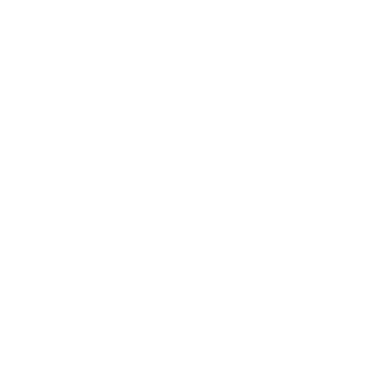

In [14]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
plt.rcParams['animation.ffmpeg_path'] = 'D:\\GoodApp\\ffmpeg\\bin\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [15]:
# 如果您有感而发，可以保存动画：.gif、.mp4 等。
anim.save("spike_mnist_test.mp4")

目标标签索引如下: 

In [16]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 3


MNIST 以灰度图像为特征，白色文本保证了每个时间步的尖峰频率为 100%。因此，我们再来一次，但要降低尖峰频率。这可以通过设置参数 `gain`来实现。在这里，我们将尖峰频率降低到 25%。

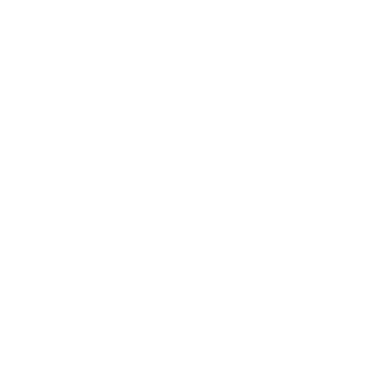

In [17]:
# 将尖峰频率降低到 25%
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

# 输出图像
spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [18]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

现在，将尖峰图像按时间平均，重建输入图像。

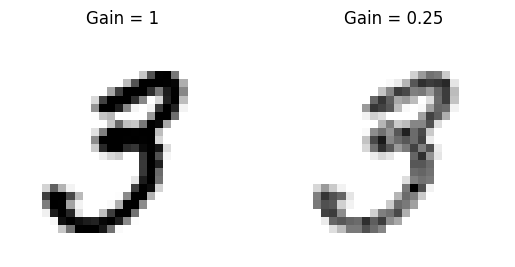

In [19]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

`gain=0.25` 的情况比 `gain=1` 的情况轻，因为尖峰概率降低了4倍。

#### 2.2.2 栅格图
或者，我们可以生成输入样本的栅格图。 这需要将样本重塑为二维张量，其中“时间”是第一个维度。 将此示例传递到函数`spikeplot.raster`。

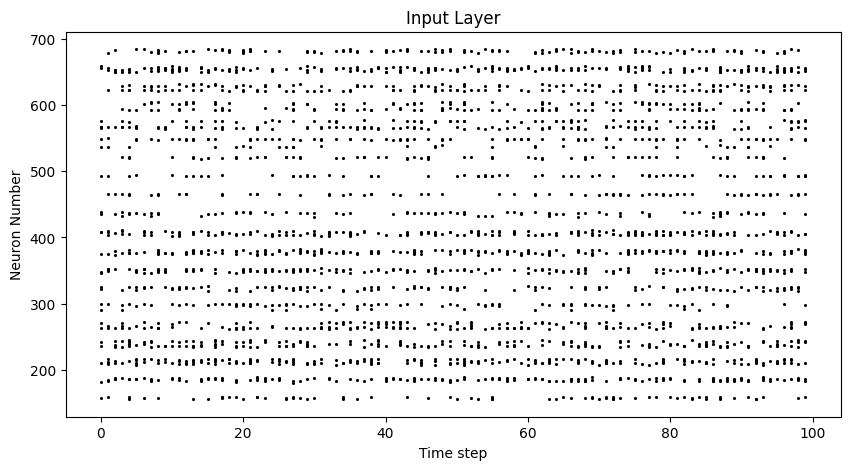

In [20]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

以下代码片段展示了如何索引单个神经元。
根据输入数据，您可能需要尝试在找到一个 0 到 784 之间的几个不同的神经元之前尖峰。

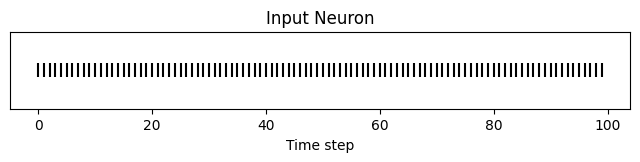

In [21]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

#### 2.2.3 速率编码总结
速率编码的想法实际上还是有争议的，尽管我们相当确信速率编码确实发生在我们的感知外围，但我们并不确信大脑皮层会将信息全面编码为尖峰速率。几个令人信服的理由包括：

* **功耗：** 自然优化效率。 完成任何任务都需要多个尖峰，而每个尖峰都会消耗能量，事实上，[Olshausen 和 Field 在“V1 的其他 85% 在做什么？”中的工作](http://www.rctn.org/bruno/papers/V1-chapter.pdf) 表明，速率编码最多只能解释初级视觉皮层 (V1) 中 15% 神经元的活动。它不可能是大脑内唯一的机制，因为大脑资源有限，而且效率很高。


* **反应响应时间：** 我们知道人类的反应时间大约在 250 毫秒左右。 如果人脑神经元的平均放电频率约为 10Hz，那么我们在反应时间尺度内只能处理大约 2 个尖峰。

那么，如果速率代码对于功率效率或延迟而言不是最佳的，那么为什么我们还要使用速率代码呢？ 即使我们的大脑不按速率处理数据，我们也相当确信我们的生物传感器会这样做。功率/延迟方面的劣势被巨大的噪声鲁棒性所部分抵消：即使有些尖峰无法产生也没关系，因为还会有更多的尖峰出现。

此外，您可能听说过[赫布咒语“神经元一起放电，连接在一起”](https://doi.org/10.2307/1418888)。 如果有大量的尖峰，这可能表明有大量的学习。 在某些情况下，训练 SNN 被证明具有挑战性，通过速率代码鼓励更多尖峰是一种可能的解决方案。

速率编码几乎肯定与大脑中的其他编码方案结合使用。 我们将在以下部分中考虑这些其他编码机制。
这涵盖了`spikegen.rate`函数。 更多信息[可以在此处的文档中找到](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)。


### 2.3 MNIST 的延迟编码
时间代码捕获有关神经元精确放电时间的信息； 单个尖峰比依赖于发射频率的速率代码具有更多的意义。 虽然这对噪声更加敏感，但它也可以将运行 SNN 算法的硬件消耗的功耗降低几个数量级。

`spikegen.latency` 是一个函数，允许每个输入在全时间扫描期间最多触发 **一次**。
接近“1”的功能将更早触发，接近“0”的功能将稍后触发。 也就是说，在我们的 MNIST 案例中，亮像素会更早触发，暗像素会稍后触发。

以下使用块驱动来解释工作原理。 如果您忘记了 电路理论/数学理论，那么不用担心！ 只要记住：**大**输入意味着**快**峰值； **小**输入意味着**迟**尖峰。


---
**可选：延迟代码机制的推导**

默认情况下，通过将输入特征视为 RC 电路中的电流注入 $I_{in}$ 来计算尖峰时序。 该电流将电荷转移到电容器上，从而增加 $V(t)$。 我们假设有一个触发电压 $V_{thr}$，一旦达到该电压，就会产生一个尖峰。 那么问题就变成了：*对于给定的输入电流（以及等效的输入特征），生成尖峰需要多长时间？*

从基尔霍夫电流定律 $I_{in} = I_R + I_C$ 开始，其余的推导使我们得出时间和输入之间的对数关系。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

以下函数使用上述结果将强度 $X_{ij}\in [0,1]$ 的特征转换为延迟编码响应 $L_{ij}$。

In [22]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

现在，使用上述函数可视化输入特征强度与其相应尖峰时间之间的关系。

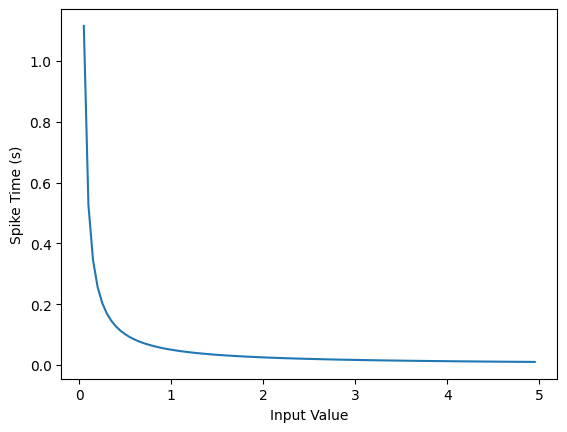

In [23]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

值越小，尖峰出现越晚，具有指数依赖性。

向量`spike_times`包含触发尖峰的时间，而不是包含尖峰本身（1 和 0）的稀疏张量。

运行 SNN 模拟时，我们需要 1/0 来表示所有尖峰。

整个过程可以使用`spikegen.latency`自动化，我们在`data_it`中传递来自 MNIST 数据集的小批量：

In [24]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

一些论点包括：

* `tau`: 电路的 RC 时间常数。 默认情况下，输入特性被视为注入 RC 电路的恒定电流。 较高的`tau`会导致产生尖峰的速度变慢。
* `threshold`：膜电位产生尖峰阈值。低于该阈值的输入值没有闭式解，因为输入电流不足以驱动膜达到阈值。所有低于阈值的值都会被剪切并分配到最后一个时间步骤。

#### 2.3.1 栅格图

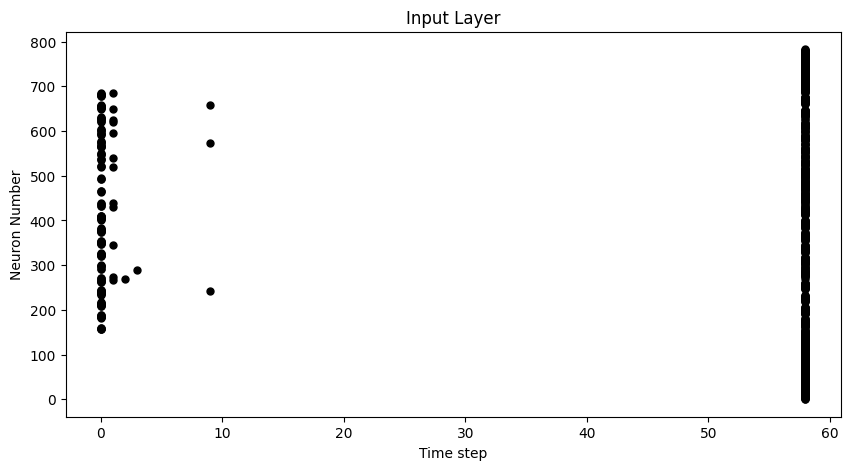

In [25]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

要理解栅格图，请注意高强度特征先产生尖峰，而低强度特征最后尖峰：

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

对数代码加上缺乏不同的输入值（即缺乏中间色调/灰度特征）导致图中两个区域出现明显的聚类。

亮像素在运行开始时产生尖峰，而暗像素则在运行结束时产生尖峰。

我们可以增加 `tau` 来减慢尖峰时间，或者通过设置可选参数 `linear=True` 来线性化尖峰时间。

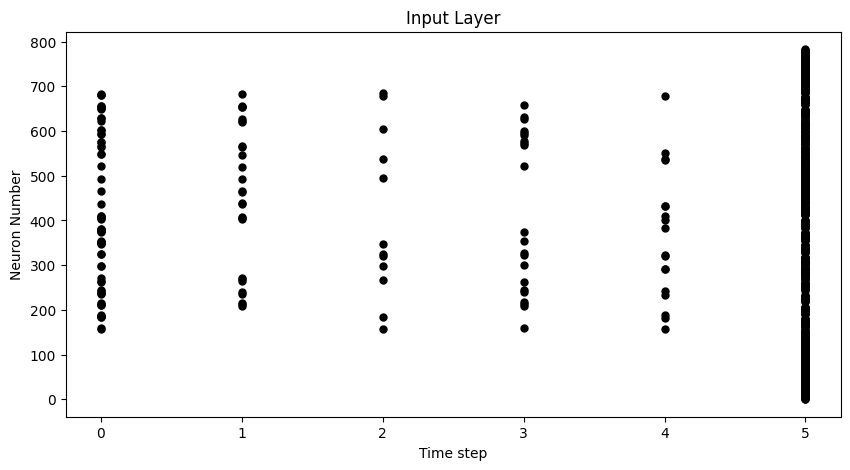

In [26]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

现在，产生尖峰的时间的分布更加均匀。这是通过将对数方程线性化来实现的，具体规则如下。与 RC 模型不同，该模型没有物理基础。它只是更简单而已。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>


但请注意，所有尖峰都发生在前约 5 个时间步内，而模拟范围是 100 个时间步。
这表明我们有很多多余的时间步没有做任何事情。要解决这个问题，可以增加 `tau` 来减慢时间常数，或者设置可选参数 `normalize=True` 来跨越整个 `num_steps` 范围。

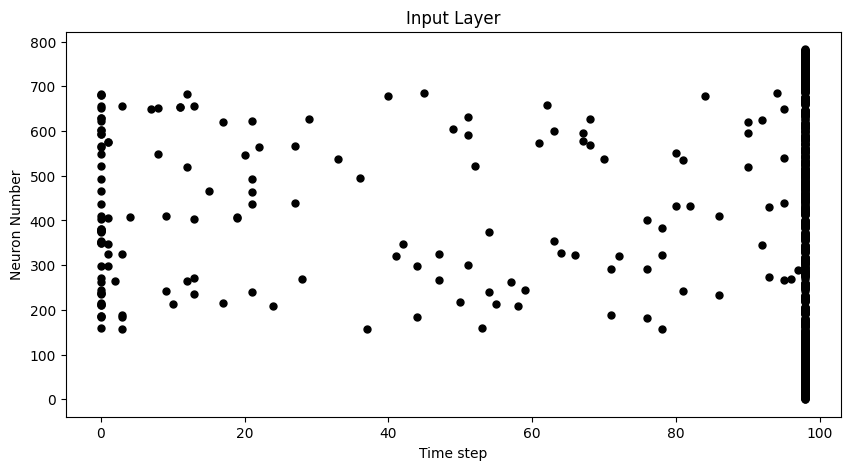

In [27]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

与速率编码相比，延迟编码的一大优势在于稀疏性。如果神经元被限制在感兴趣的时间过程中只产生一次尖峰，那么这将促进低功耗运行。

在上图所示的场景中，大部分尖峰发生在最后一个时间步长，此时输入特征低于阈值。从某种意义上说，MNIST 样本的深色背景并不包含有用的信息。

我们可以通过设置 `clip=True` 来去除这些冗余特征。

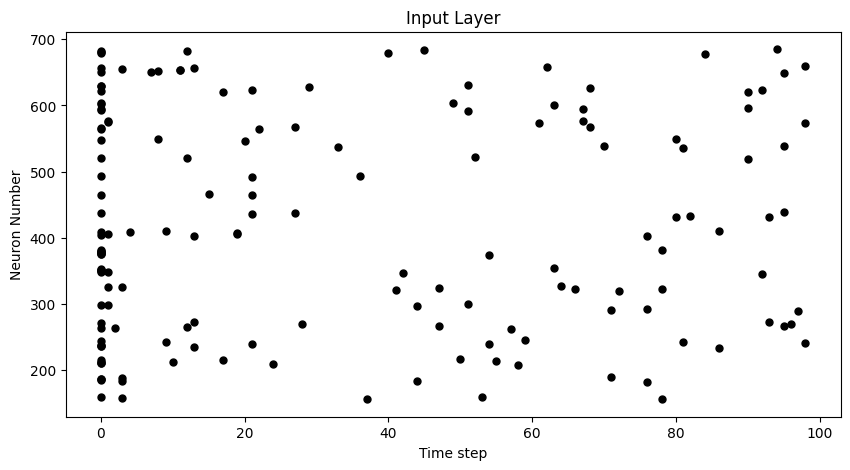

In [28]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

这样看起来就好多了

#### 2.3.2 动画化
我们将运行与之前完全相同的代码块来创建动画。

In [29]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


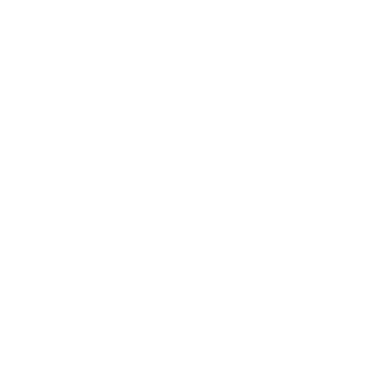

In [30]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

该动画显然以视频形式更难看清，但敏锐的眼睛将能够瞥见大多数尖峰发生的初始帧。

索引到相应的目标值以检查其值。

In [31]:
# Save output: .gif, .mp4 etc.
# anim.save("mnist_latency.gif")

In [32]:
print(targets_it[0])

tensor(3)


这就是`spikegen.latency`函数。 更多信息[可以在此处的文档中找到](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)。

### 2.4 Delta 调制 / 增量调制

有理论认为视网膜具有适应性：只有当有新的东西需要处理时，它才会处理信息。  如果您的视野没有变化，那么您的感光细胞就不太容易放电。

也就是说：**生物学是事件驱动的**。  神经元在变化中茁壮成长。

举一个有趣的例子，一些研究人员毕生致力于设计受视网膜启发的图像传感器，例如 [动态视觉传感器](https://ieeexplore.ieee.org/abstract/document/7128412/)。  尽管 [所附链接来自十多年前，但该视频中的工作](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck) 是超前的。

增量调制基于事件驱动的尖峰。 `snntorch.delta` 函数接受时间序列张量作为输入。  它获取所有时间步骤中每个后续特征之间的差异。  默认情况下，如果差异均为 *正* 且 *大于阈值 $V_{thr}$*，则会生成尖峰：

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

为了说明这一点，我们首先举一个人为例子，在其中创建我们自己的输入张量。

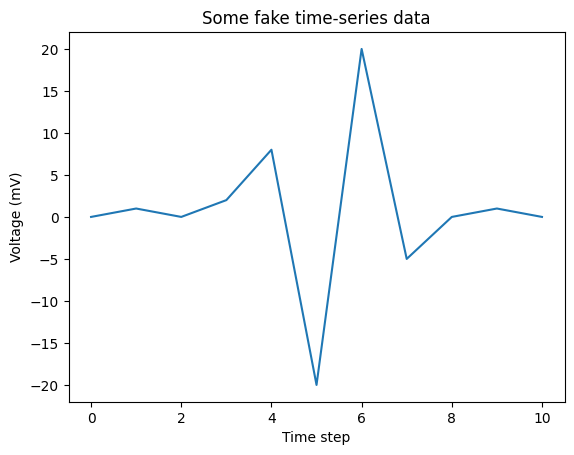

In [33]:
# 使用一些虚假的时间序列数据创建一个张量
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

将上述张量传递到 `spikegen.delta` 函数中，并任意选择 `threshold=4`：

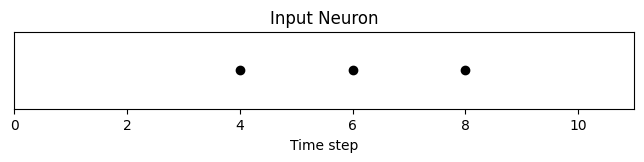

In [34]:
# 转换数据
spike_data = spikegen.delta(data, threshold=4)

# 生成 fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# 增量转换数据的栅格图
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

在三个时间步中，$data [T]$ 和 $data [T+1]$ 之间的差值大于或等于 $V_{thr}=4$。  这意味着存在三个 “尖峰”。

上面没有捕捉到 -20 的大幅下降。 如果负波动对您的数据很重要，您可以启用可选参数 `off_spike=True`。

注： -20是上面data的输入数据。

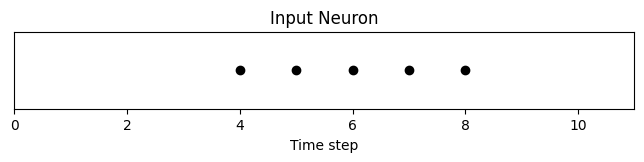

In [35]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

我们已经生成了额外的峰值，但这实际上并不是完整的图片！

 打印张量将显示 “非尖峰” 的存在，其值为 “-1”。

In [36]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


虽然`spikegen.delta`仅在假数据样本上进行了演示，但其真正用途是通过仅针对足够大的变化/事件生成尖峰来压缩时间序列数据。

这包含了三个主要的尖峰转换函数！ 这三种转换技术中的每一种还有一些本教程中未详细介绍的附加功能。 特别是，我们只研究了对输入数据进行编码； 我们还没有考虑如何对目标进行编码，以及何时需要编码。 我们建议[参考文档进行更深入的研究](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)。

## 3. 尖峰生成器（可选）

现在，如果我们实际上没有任何数据可以开始怎么办？
假设我们只想从头开始随机生成一个尖峰序列。代替`spikegen.rate`是一个嵌套函数 `rate_conv`，它实际上执行尖峰转换步骤。

我们所要做的就是初始化一个随机生成的 `torchTensor` 并传入。

In [37]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

### 3.1 动画

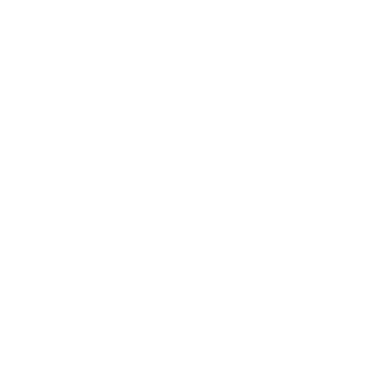

In [38]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

In [39]:
# Save output: .gif, .mp4 etc.
# anim.save("random_spikes.gif")

### 3.2 栅格图

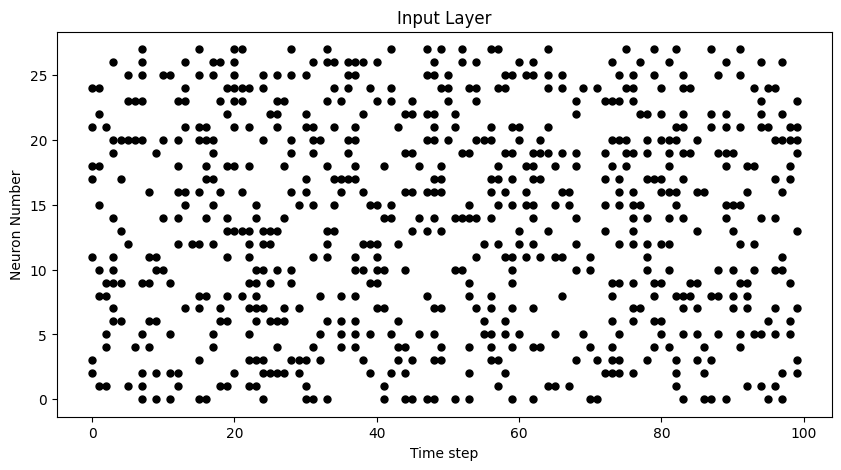

In [40]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# 总结


这就是尖峰转换和生成。

这种方法可以推广到图像之外的单维和多维张量。

作为参考，[`spikegen` 的文档可以在这里找到](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html) 和 [`spikeplot`，在这里](https:// snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)

[在下一个教程中](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)，您将学习尖峰神经元的基础知识以及如何使用它们。

如果您喜欢这个项目，请考虑为 GitHub 上的存储库加注星标，因为这是支持它的最简单、最好的方式。

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)